## 2. Loading the Data

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [169]:
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section


df = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)

df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  
0  [{'content': 'What is the difference between O...  
1  [{'content': 'Why did my parent not invite me ...  
2  [{'content': 'Fuji vs. Nikon, which is better?...  
3  [{'content': 'How to build an arena for chatbo...  
4  [{'content': 'When is it today?', 'role': 'use...

In [170]:
df.shape

(25282, 7)

In [171]:
df = df.sample(n=12_500, random_state = 42) # sample ~80% of census , set seed to 42

In [172]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

In [173]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"

)

response_a_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [174]:
prompt_embeddings = pd.DataFrame(prompt_embeddings).sample(n=12_500, random_state=42)
response_a_embeddings = pd.DataFrame(response_a_embeddings).sample(n=12_500, random_state=42)
response_b_embeddings = pd.DataFrame(response_b_embeddings).sample(n=12_500, random_state=42)
topic_and_hardness = pd.DataFrame(topic_and_hardness).sample(n=12_500, random_state=42)

## 3. Exploring the Data

### Converstation Data

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`). It is in JSON line format, compressed with `gzip`. You can load the data with `pd.read_json`.

Before diving into any analysis, it's important to understand the structure of the dataset. In this section, we'll check the basic details of the data, such as the number of rows, column names, data types, and any missing values.

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12500 entries, 1668 to 6263
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     12500 non-null  object
 1   model_a         12500 non-null  object
 2   model_b         12500 non-null  object
 3   winner          12500 non-null  object
 4   judge           12500 non-null  object
 5   conversation_a  12500 non-null  object
 6   conversation_b  12500 non-null  object
dtypes: object(7)
memory usage: 781.2+ KB


In [176]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

As an example to guide you through the exploratory process, let‚Äôs investigate the length distribution of the prompt. This helps answer questions like (this is related to the ``Distribution of the prompt and response length'' requirement of the EDA assingment).
: 

- Do the arena users ask long or short questions?
**Most of the prompts are quite short with some rare exception of someone that wrote a 2500 character question.**
- What is the average length of prompts that users give to the chatbots?
 **196 is the mean but that is a poor way to messure it becuase there is such a long tail 72.**

By analyzing the length of the prompts, you can start forming hypotheses about how the length might affect model performance or user votes. This example will guide you in asking similar questions about other aspects of the dataset.

In [177]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)

1668    Tell me about birds
Name: prompt, dtype: object

In [178]:
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count    12500.000000
mean       199.510960
std        375.692894
min         16.000000
25%         42.000000
50%         72.000000
75%        158.000000
max       2560.000000
Name: prompt_length, dtype: float64

Looks like the mean length of the prompt is about **200 characters, while the median is 72 characters**. This suggests that the distribution is **right-skewed!** Let's visualize this.

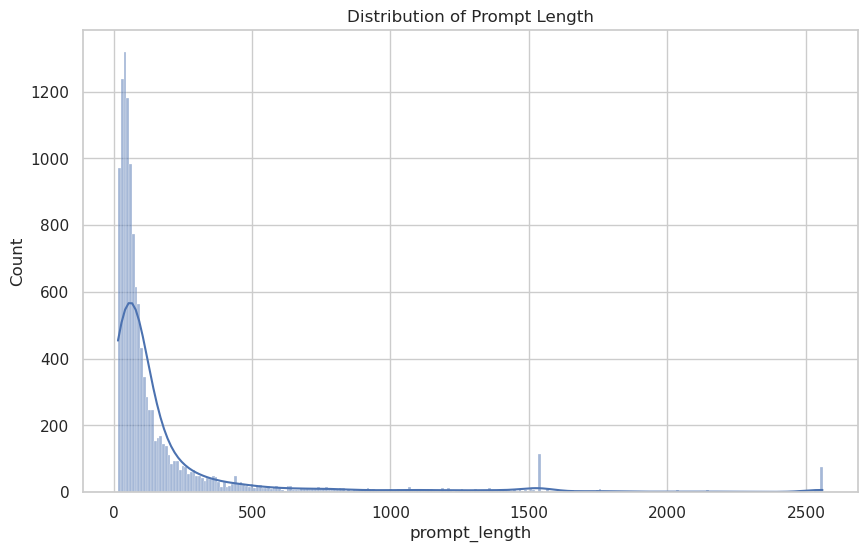

In [ ]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

plt.title("Distribution of Prompt Length")

#save graph
# plt.# savefig("figures/prompt_length_distribution.png", dpi=300, bbox_inches='tight')

Now, can you apply the same thought process to visualize the distribution of the response length? 

Applying the same logic you used to make the `prompt` column, you should also make the columns `model_a_response` and `model_b_response` by extracting the **second half** of the content from `conversation_a` and `conversation_b` respectively in order to look into specific content of the model responses.

In [180]:
df["model_a_response"] = df["conversation_a"].str[1].str["content"] # model_a_response
df["model_a_response"][0] # model_a_response from the first conversation

'OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purposeÂπ∂Ë°åÁºñÁ®ãÊé•Âè£ that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, andÂõæÂΩ¢ÂõæÂÉèÂ§ÑÁêÜ. The CUDA API provides a high-level, more efficient way to write parallel code that can run on top of a GPU, while still maintaining the ability to write code that can be easily adapted for other parallel computing platforms.'

In [181]:
df["conversation_a_length"] = df["model_a_response"].str.len() # model_a_response length
df["conversation_a_length"].describe() # summary statistics of conversation_a_length

count    12500.000000
mean       772.369280
std        653.312165
min          1.000000
25%        232.000000
50%        588.000000
75%       1210.000000
max       6434.000000
Name: conversation_a_length, dtype: float64

In [182]:
df["model_b_response"] = df["conversation_b"].str[1].str["content"] # model_b_response
df["model_b_response"].head() # model_b_response from the first conversation

1668     Birds are a group of vertebrates, or air-breat...
11376    The main differences between 2.4GHz and 5GHz W...
4347     One concrete thing you can do today to innovat...
12559    **EXT. MUSIC HALL - NIGHT**\n\nA large crowd o...
8696     A core React project template for creating mul...
Name: model_b_response, dtype: object

In [183]:
df["conversation_b_length"] = df["model_b_response"].str.len() # model_b_response length
df["conversation_b_length"].describe() # summary statistics of conversation_b_length

count    12500.000000
mean       772.933840
std        660.049699
min          1.000000
25%        233.000000
50%        573.000000
75%       1223.000000
max       7135.000000
Name: conversation_b_length, dtype: float64

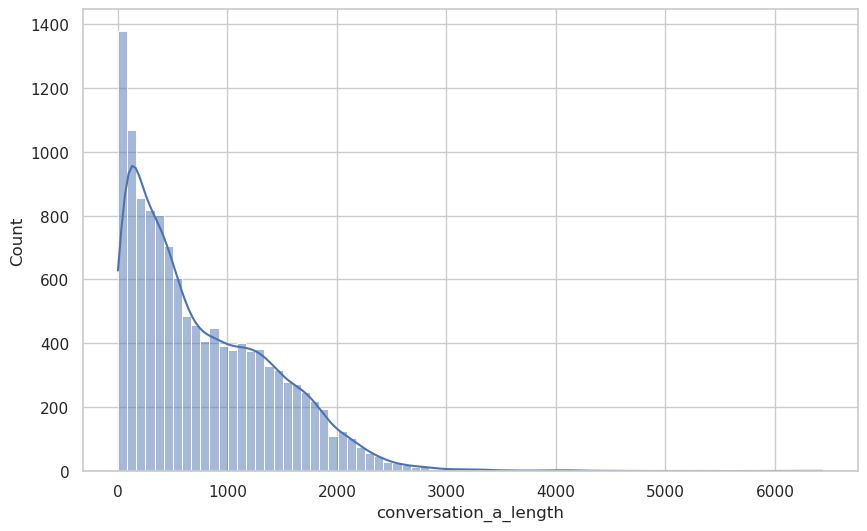

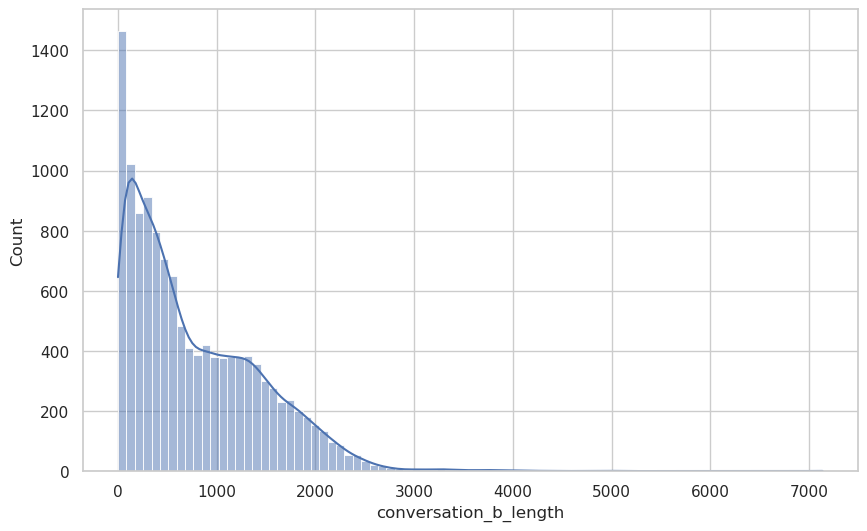

In [ ]:
#plot the distribution of the length of the model_a_response
plt.figure(figsize=(10, 6))
sns.histplot(df["conversation_a_length"], kde=True)

plt.figure(figsize=(10, 6))
sns.histplot(df["conversation_b_length"], kde=True)

# plt.# savefig("figures/conversation_a_length_distribution.png", dpi=300, bbox_inches='tight')
# plt.# savefig("figures/conversation_b_length_distribution.png", dpi=300, bbox_inches='tight')

### Embedding Data

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Concretely, the auxiliary dataset,`./chatbot-arena-prompts-embeddings.npy`, `./chatbot-arena-model_a_response-embeddings.npy`, and `./chatbot-arena-model_b_response-embeddings.npy`, contains 256-dimensional text embeddings for each of the human questions, model a responses and model b responses respectively. 

In this section, we will walk you through an example of computing the similarity between prompts using the precomputed embeddings (`./chatbot-arena-prompts-embeddings.npy`). The goal is to find prompts that are most similar to a given prompt based on their embeddings.

Before we get started, let's first load and output the `propmt_embeddings` which we have loaded in the second section to see what they look like. Each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

The embeddings are a matrix where each row corresponds to a prompt from the dataset. Each row is a 256-dimensional vector that captures the semantic meaning of the prompt.

In [186]:
prompt_embeddings.shape

(12500, 256)

The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.
(This is related to the ``(Open-ended) Explore the prompt topics in the dataset (topic modeling).'' requirement of the EDA assignment)

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [187]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = prompt_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [188]:
source_prompt_idx = 23
source_prompt = df.iloc[source_prompt_idx].prompt
source_prompt

'This is what it sounds like, when doves cry.'

The prompt we're using as a reference (index 23) is:

`'Write me a function to lazily compute a Fibonacci sequence in Clojure.'`

Now let's find the top 5 most similar prompts to this one.

In [189]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].prompt
similar_promts.tolist()

['This is what it sounds like, when doves cry.',
 'Do you think crying is a sign of weakness or strength?',
 'What is the sound of one hand clapping? ü§î',
 'The dark sky impulses some digits in my heart. Rewrite it to be a poem',
 "Write me the shortest sad story. It shouldn't be more than 10 words."]

As you can see, these prompts are closely related to programming tasks, many of them dealing with functions and computations. This shows how embeddings can group semantically similar questions together.

You also have the embeddings for responses from models a (`./chatbot-arena-model_a_response-embeddings.npy`) and model b (`./chatbot-arena-model_b_response-embeddings.npy`) respectively to explore. (These are the embeddings from columns `model_a_response` and `model_b_response` which can be created by extracting the second half of columns `conversation_a` and `conversation_b` respectively (as explained in the previous section).

Potential follow-up questions you can explore: 
- Can you identify clusters of similar topics within the dataset?

    **Yes, utilizing K-means, We can view closely related prompts via their embeddings_sample. This will help us visualize how closely related each point is to another by grouping them into clusters based on their distances.**

- How do different models perform on similar prompts?
    **It seems that the models responses vary across the similar prompts. We see that similar responses are different depending on the model used. Hence, there may be different performances between the models.**

- Can you find examples where semantically similar prompts result in different outcomes?

    **Yes, comparing the models, the similar prompts resulted in different similarities between the responses. This indicates that the model provides inconsistent output depending on what model is used.**

## KMEANS

question_id                  model_a  \
1668   eda01e1362fe4ba29fd4a5ae86fb7a73  stablelm-tuned-alpha-7b   
11376  9183fd27cf24467baca122d23e6a8806               vicuna-13b   
4347   5a3fab1649c742ad95e263bb62195407           fastchat-t5-3b   
12559  6b6f60abc11749f38f33eb704fc3a7f3         RWKV-4-Raven-14B   
8696   0a93243f1657485c8b091a8ca85116b2                    gpt-4   
...                                 ...                      ...   
8914   75411df77675407e8450d835d9e738ef         oasst-pythia-12b   
13477  eac35cd2993f487792f94d8d97d9e706         oasst-pythia-12b   
14808  a1d6006fa511430b9a0a0e16f24ea499                   palm-2   
13626  5a0886b2d84d4498b184dfb3afffbe13            gpt-3.5-turbo   
6263   7dfe92bddb924a1a9c6d5bc314933480  stablelm-tuned-alpha-7b   

                model_b   winner             judge  \
1668          llama-13b  model_a   arena_user_2496   
11376         claude-v1  model_b  arena_user_11136   
4347              gpt-4  model_b   arena_user_5757   
12559            palm-2  model_b  arena_user_11725   
8696      gpt-3.5-turbo  model_a   arena_user_9014   
...                 ...      ...               ...   
8914          claude-v1  model_b   arena_user_9619   
13477        vicuna-13b  model_b  arena_user_12556   
14808  RWKV-4-Raven-14B  model_b  arena_user_13410   
13626  RWKV-4-Raven-14B  model_a   arena_user_8096   
6263   oasst-pythia-12b  model_a   arena_user_7046   

                                          conversation_a  \
1668   [{'content': 'Tell me about birds', 'role': 'u...   
11376  [{'content': 'what is the difference between 2...   
4347   [{'content': 'How can I innovate today? Give m...   
12559  [{'content': 'Write a long, original, artistic...   
8696   [{'content': 'Write an explanation of a core r...   
...                                                  ...   
8914   [{'content': 'Write a Shakespearean poem in ia...   
13477  [{'content': 'why is the sun visible at night?...   
14808  [{'content': 'come up with an original strateg...   
13626  [{'content': 'Write a math joke. It must conta...   
6263   [{'content': 'What is breakcore?', 'role': 'us...   

                                          conversation_b  \
1668   [{'content': 'Tell me about birds', 'role': 'u...   
11376  [{'content': 'what is the difference between 2...   
4347   [{'content': 'How can I innovate today? Give m...   
12559  [{'content': 'Write a long, original, artistic...   
8696   [{'content': 'Write an explanation of a core r...   
...                                                  ...   
8914   [{'content': 'Write a Shakespearean poem in ia...   
13477  [{'content': 'why is the sun visible at night?...   
14808  [{'content': 'come up with an original strateg...   
13626  [{'content': 'Write a math joke. It must conta...   
6263   [{'content': 'What is breakcore?', 'role': 'us...   

                                                  prompt  prompt_length  \
1668                                 Tell me about birds             19   
11376  what is the difference between 2.4g and 5g in ...             51   
4347   How can I innovate today? Give me one concrete...             79   
12559  Write a long, original, artistic, imaginative,...            905   
8696   Write an explanation of a core react project t...            117   
...                                                  ...            ...   
8914   Write a Shakespearean poem in iambic pentamete...            125   
13477                   why is the sun visible at night?             32   
14808  come up with an original strategy to improve p...            105   
13626  Write a math joke. It must contain the word 'b...             66   
6263                                  What is breakcore?             18   

                                        model_a_response  \
1668   Birds are a diverse group of living organisms ...   
11376  2.4 GHz and 5 GHz are two different frequency ...   
4347   Innovation is the process of cre

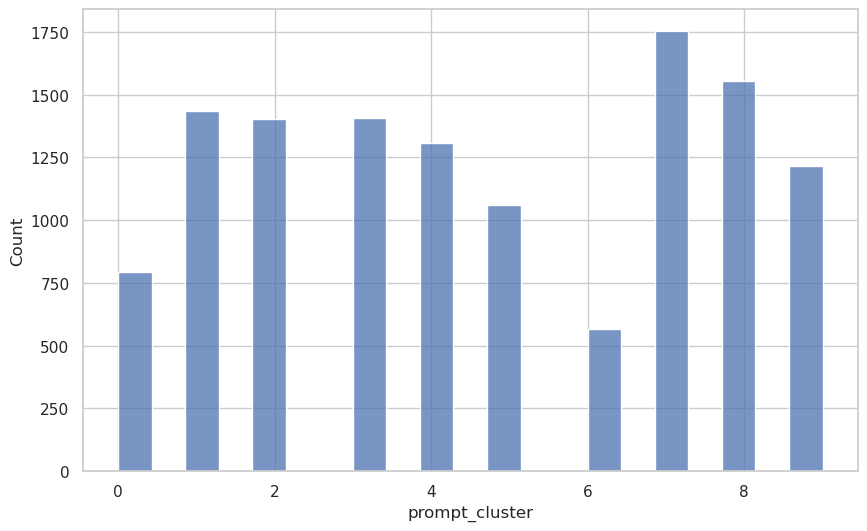

In [ ]:
# Find clusters of similar prompts using KMeans for Prompts
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_sample)

df["prompt_cluster"] = kmeans.predict(prompt_embeddings)

df["prompt_cluster"].value_counts()

# Plot the distribution of the prompt clusters (10 clusters)
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_cluster"], kde=False)

# plt.# savefig("figures/prompt_clusters_distribution.png", dpi=300, bbox_inches='tight')

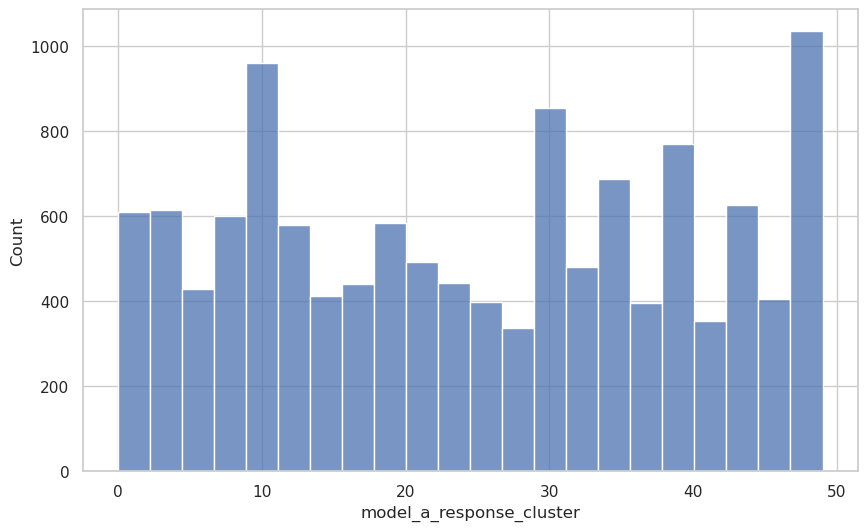

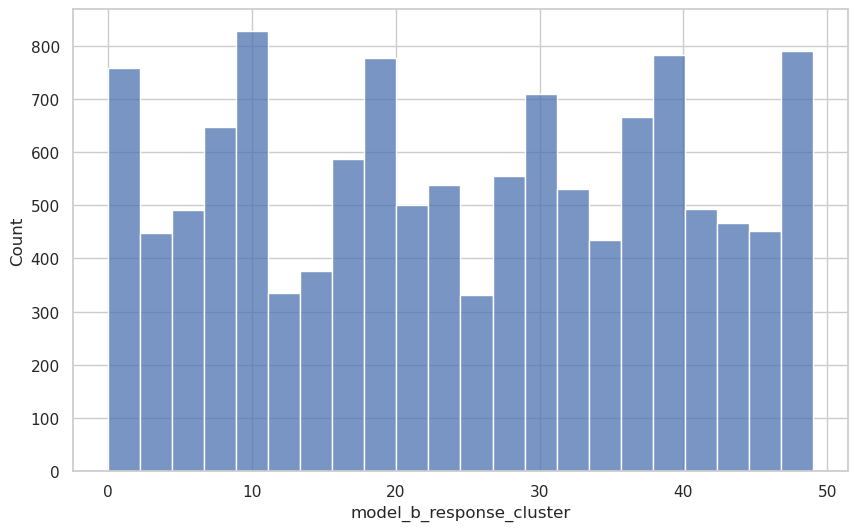

In [ ]:
# Kmeans for Model A Responses
response_a_embeddings.shape

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_a_embeddings)

df["model_a_response_cluster"] = kmeans.predict(response_a_embeddings)
df["model_a_response_cluster"].value_counts()

# Plot the distribution of the model A response clusters (10 clusters)
plt.figure(figsize=(10, 6))
sns.histplot(df["model_a_response_cluster"], kde=False)

# plt.# savefig("figures/model_a_response_clusters_distribution.png", dpi=300, bbox_inches='tight')

# Kmeans for Model B Responses
response_b_embeddings.shape

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_b_embeddings)

df["model_b_response_cluster"] = kmeans.predict(response_b_embeddings)
df["model_b_response_cluster"].value_counts()

# Plot the distribution of the model B response clusters (10 clusters)
plt.figure(figsize=(10, 6))
sns.histplot(df["model_b_response_cluster"], kde=False)

# plt.# savefig("figures/model_b_response_clusters_distribution.png", dpi=300, bbox_inches='tight')


## Hardness Score Data Inspection

### Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks. 

For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

**_Warning_: This data can be messy! This is intentionally not cleaned up for you to resemble real-world data. You are responsible for figuring out the irregularities and cleaning it up. The following cells demonstrate the example of messy data.**

In [192]:
# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [193]:
topic_and_hardness.head(5)

question_id  \
0  58210e39b3fd4441a2bd4a518bb44c2d   
1  2564acd09e3942fd97657d05282d4389   
2  90bfd142157948aba01931726c888e7f   
3  a7c5accc53e649a3bc6b2e41d962ebc4   
4  adf27e819a3c494cb6e993f0c660e097   

                                              prompt  \
0    What is the difference between OpenCL and CUDA?   
1  Why did my parent not invite me to their wedding?   
2                   Fuji vs. Nikon, which is better?   
3                How to build an arena for chatbots?   
4                                  When is it today?   

                    openai_scores_raw_choices_nested      topic_modeling_1  \
0  [{'finish_reason': 'stop', 'index': 0, 'logpro...  Technical Comparison   
1  [{'finish_reason': 'stop', 'index': 0, 'logpro...    Reasoning, Emotion   
2  [{'finish_reason': 'stop', 'index': 0, 'logpro...     Camera comparison   
3  [{'finish_reason': 'stop', 'index': 0, 'logpro...         Chatbot Arena   
4  [{'finish_reason': 'stop', 'index': 0, 'logpro...            Time Query   

                                      score_reason_1 score_value_1  \
0  This prompt requires the AI to accurately comp...             9   
1  This prompt requires the AI to understand huma...             9   
2  This prompt does not require problem-solving s...             2   
3  This prompt requires problem-solving skills an...             8   
4  This prompt is very straightforward and does n...             2   

          topic_modeling_2                                     score_reason_2  \
0      Software Comparison  This prompt assesses the AI's factual accuracy...   
1  Emotions, Relationships  This prompt involves understanding complex hum...   
2     Comparative Analysis  This prompt assesses the AI's ability to analy...   
3            Chatbot Arena  This prompt requires the AI to engage in probl...   
4             Date Inquiry  This prompt is very straightforward and does n...   

  score_value_2        topic_modeling_3  \
0             8  Comparison, Technology   
1             8    Reasoning, Emotional   
2             6  Photography comparison   
3             8           Chatbot Arena   
4             2      Time-based Inquiry   

                                      score_reason_3 score_value_3  
0  This prompt requires the AI to demonstrate kno...             9  
1  This prompt challenges the AI to infer motives...             8  
2  This prompt is subjective and does not provide...             2  
3  This prompt requires problem-solving skills an...             8  
4  This prompt is too straightforward and simply ...             2

**Understand the Structure**
How are the topic modeling and hardness scores structured across the dataset?
- Look at the columns `topic_modeling_1`, `score_reason_1`, `score_value_1`, etc.
- How consistent are the values across the rows? Do they follow a pattern? Are there any irregularities or unexpected values?

<mark> When comparing score_reason_1 and score_value_1, <b><span style="color: red;"> low values </span></b> in the column <b>score_value_1</b> are associated with <b><span style="color: red;">"not require problem-solving" or "straightforward" </span></b>reasons in column <b>score_reason_1 </b>. <b><span style="color: blue;">High values</span></b> in score_value_1 are associated with <b><span style="color: blue;">"requires...accurately", "requires problem-solving", "requires...demonstrate", and other requirements that make the questions less straightforawrd </span></b> for the AI bots to answer. 

In [194]:
topic_and_hardness[['topic_modeling_1', 'score_reason_1', 'score_value_1']].head(10)#.sort_values(by="score_value_1")

topic_modeling_1  \
0            Technical Comparison   
1              Reasoning, Emotion   
2               Camera comparison   
3                   Chatbot Arena   
4                      Time Query   
5              Counting Sequences   
6                 Emoji Selection   
7  Neural Network Parallelization   
8          Arithmetic Calculation   
9         Mathematical Operations   

                                      score_reason_1 score_value_1  
0  This prompt requires the AI to accurately comp...             9  
1  This prompt requires the AI to understand huma...             9  
2  This prompt does not require problem-solving s...             2  
3  This prompt requires problem-solving skills an...             8  
4  This prompt is very straightforward and does n...             2  
5  This prompt measures the AI's problem-solving ...             7  
6  Selecting the appropriate emojis that represen...             7  
7  This prompt requires the AI to demonstrate pro...             8  
8  This prompt is straightforward and only involv...             2  
9  This prompt involves a basic arithmetic operat...             2

In [195]:
# topic_and_hardness[['topic_modeling_1', 'score_value_1']].sort_values(by="score_value_1", ascending=False)['topic_modeling_1'].head(10)

**Data Cleaning**
The following are some of the things (many) you should explore to clean your data:
- Are there any missing values?
- The data in the `openai_scores_raw_choices_nested` field appears messy. It contains a list of nested dictionaries that might need to be flattened for easier analysis. Consider these points:
    - Do you need all the nested data? Perhaps you only need the final hardness scores and topic modeling results for your analysis.
    - One way to deal with the nested openai_scores_raw_choices_nested field is to flatten it into more readable columns if you find you need the nested data.
- Sometimes, there could be repeated entries in the dataset. Make sure that each question (question_id) and its corresponding responses are unique.

Let‚Äôs begin by checking for missing values in our dataset.

In [196]:
topic_and_hardness.isnull().sum() # count of missing values in topic_and_hardness

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    26
score_reason_1                      26
score_value_1                       26
topic_modeling_2                    26
score_reason_2                      26
score_value_2                       26
topic_modeling_3                    26
score_reason_3                      26
score_value_3                       26
dtype: int64

What are some strategies for handling missing values?

Messy data is not only about missing values, it can also be about inconsistent formatting. Let's check for inconsistencies in the `score_value_1` column of the dataset. The `score_value_1` field should contain numerical values representing hardness scores. However, sometimes data can be messy, and we might encounter values that are not in the expected format (e.g., lists instead of single numbers).

The code below demonstrates how to identify rows where `score_value_1` is incorrectly formatted as a list:

In [197]:
topic_and_hardness["score_value_1"][
    topic_and_hardness["score_value_1"].apply(lambda x: isinstance(x, list))
].head()

12     [[8]]
48     [[7]]
86     [[7]]
144    [[8]]
181    [[7]]
Name: score_value_1, dtype: object

Why do you think `score_value_1` contains lists instead of single values? What might have caused this? What steps would you take to fix this issue so that `score_value_1` contains only numeric values? Are there any other columns that might have similar issues?

In [198]:
topic_and_hardness.shape

(25282, 12)

In [199]:
# Drop the rows with 0's (only 26 of 25282 rows):
topic_and_hardness.dropna(inplace=True)
print(topic_and_hardness.shape)
topic_and_hardness.isnull().sum()

(25256, 12)


question_id                         0
prompt                              0
openai_scores_raw_choices_nested    0
topic_modeling_1                    0
score_reason_1                      0
score_value_1                       0
topic_modeling_2                    0
score_reason_2                      0
score_value_2                       0
topic_modeling_3                    0
score_reason_3                      0
score_value_3                       0
dtype: int64

In [200]:
def take_out_list(one_series_element): 
    """
    This function takes a series element and returns the first element of the first list if it is a list,
    otherwise it returns the element itself.
    :param one_series_element: The series element to be processed.
    :return: The first element of the first list or the element itself.
    """
    if isinstance(one_series_element, list):
        return one_series_element[0][0]
    else:
        return one_series_element

In [201]:
score_value_1_cleaned = topic_and_hardness["score_value_1"].apply(take_out_list) #this will take out the first element of the first list if it is a list, otherwise it will return the element itself.
condition = score_value_1_cleaned.apply(lambda x: isinstance(x, list)) #this will check if the element is a list
topic_and_hardness[condition] #this will show the rows where the element is a list

Empty DataFrame
Columns: [question_id, prompt, openai_scores_raw_choices_nested, topic_modeling_1, score_reason_1, score_value_1, topic_modeling_2, score_reason_2, score_value_2, topic_modeling_3, score_reason_3, score_value_3]
Index: []

In [202]:
score_value_2_cleaned = topic_and_hardness["score_value_2"].apply(take_out_list) #this will take out the first element of the first list if it is a list, otherwise it will return the element itself. 
score_value_3_cleaned = topic_and_hardness["score_value_3"].apply(take_out_list) #this will take out the first element of the first list if it is a list, otherwise it will return the element itself.

In [203]:
topic_and_hardness["score_value_1"] = score_value_1_cleaned 
topic_and_hardness["score_value_2"] = score_value_2_cleaned
topic_and_hardness["score_value_3"] = score_value_3_cleaned

In [204]:
print(topic_and_hardness.shape)
topic_and_hardness.head(3)

(25256, 12)


question_id  \
0  58210e39b3fd4441a2bd4a518bb44c2d   
1  2564acd09e3942fd97657d05282d4389   
2  90bfd142157948aba01931726c888e7f   

                                              prompt  \
0    What is the difference between OpenCL and CUDA?   
1  Why did my parent not invite me to their wedding?   
2                   Fuji vs. Nikon, which is better?   

                    openai_scores_raw_choices_nested      topic_modeling_1  \
0  [{'finish_reason': 'stop', 'index': 0, 'logpro...  Technical Comparison   
1  [{'finish_reason': 'stop', 'index': 0, 'logpro...    Reasoning, Emotion   
2  [{'finish_reason': 'stop', 'index': 0, 'logpro...     Camera comparison   

                                      score_reason_1  score_value_1  \
0  This prompt requires the AI to accurately comp...            9.0   
1  This prompt requires the AI to understand huma...            9.0   
2  This prompt does not require problem-solving s...            2.0   

          topic_modeling_2                                     score_reason_2  \
0      Software Comparison  This prompt assesses the AI's factual accuracy...   
1  Emotions, Relationships  This prompt involves understanding complex hum...   
2     Comparative Analysis  This prompt assesses the AI's ability to analy...   

   score_value_2        topic_modeling_3  \
0              8  Comparison, Technology   
1              8    Reasoning, Emotional   
2              6  Photography comparison   

                                      score_reason_3  score_value_3  
0  This prompt requires the AI to demonstrate kno...            9.0  
1  This prompt challenges the AI to infer motives...            8.0  
2  This prompt is subjective and does not provide...            2.0

In [205]:
# Need to join main dataset with topic_and_hardness dataset to answer their following questions.
df_topic_and_hardness = pd.merge(df, topic_and_hardness, on='question_id', how='inner')

In [206]:
# Drop unnecessary column 
df_topic_and_hardness.drop(columns=["openai_scores_raw_choices_nested"],inplace = True)

In [207]:
df_topic_and_hardness.shape

(12496, 26)

In [208]:
df_topic_and_hardness.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt_x', 'prompt_length',
       'model_a_response', 'conversation_a_length', 'model_b_response',
       'conversation_b_length', 'prompt_cluster', 'model_a_response_cluster',
       'model_b_response_cluster', 'prompt_y', 'topic_modeling_1',
       'score_reason_1', 'score_value_1', 'topic_modeling_2', 'score_reason_2',
       'score_value_2', 'topic_modeling_3', 'score_reason_3', 'score_value_3'],
      dtype='object')

In [209]:
# Feature engineer: average_hardness_score
df_topic_and_hardness['row_average'] = df_topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)

In [210]:
# Answering the question: "Do models perform differently based on hardness scores?"
winner_and_hardness = df_topic_and_hardness[['winner', 'score_value_1', 'score_value_2', 'score_value_3']]

# Get rid of duplicate rows
winner_and_hardness = winner_and_hardness.drop_duplicates()

# Need to make compare winners with their average scores. 
winner_and_hardness.groupby("winner").agg("mean")

# Answer: No

score_value_1  score_value_2  score_value_3
winner                                                    
model_a             5.524887       5.307692       5.484163
model_b             5.412727       5.336364       5.457727
tie                 5.625806       5.696774       5.529032
tie (bothbad)       5.505556       5.538889       5.422222

In [211]:
winner_and_hardness

winner  score_value_1  score_value_2  score_value_3
0            model_a            2.0              7            7.0
1            model_b            7.0              7            7.0
2            model_b            8.0              9            9.0
3            model_b            9.0              9            9.0
4            model_a            8.0              9            9.0
...              ...            ...            ...            ...
12309        model_b            9.0              3            9.0
12417            tie            4.0              3            6.0
12432            tie            2.0              8            3.0
12454            tie            4.0              2            7.0
12473  tie (bothbad)            4.0              8            7.0

[776 rows x 4 columns]

## Hardness Score Visualizations

In [212]:
#sns.violinplot(data = winner_and_hardness)#, hue = "winner");

In [213]:
winner_and_hardness_melt = winner_and_hardness.melt(id_vars=["winner"], value_vars = ['score_value_1', 'score_value_2', 'score_value_3'], var_name = "score_value_type", value_name = "score")
winner_and_hardness_melt.head(3)

winner score_value_type  score
0  model_a    score_value_1    2.0
1  model_b    score_value_1    7.0
2  model_b    score_value_1    8.0

In [215]:
# Feature engineer: winning model column
def winning_model(row):
    if row['winner'] == 'model_a':
        return row['model_a']
    elif row['winner'] == 'model_b':
        return row['model_b']
    else:
        return 'tie'

df_topic_and_hardness['winning model'] = df_topic_and_hardness.apply(winning_model, axis=1)

In [217]:
# Feature engineer: One-hot encoded winning model column (could be useful for later) 
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder() # instantiate the onehotencoder class
one_hot.fit(df_topic_and_hardness[['winning model']]) # Choose the column with the categories
one_hot_winning_models = one_hot.transform(df_topic_and_hardness[['winning model']]).toarray()
one_hot_winning_models = pd.DataFrame(data=one_hot_winning_models, columns = one_hot.get_feature_names_out(), index = df_topic_and_hardness.index)

winning model_RWKV-4-Raven-14B  winning model_alpaca-13b  \
0                                 0.0                       0.0   
1                                 0.0                       0.0   
2                                 0.0                       0.0   
3                                 0.0                       0.0   
4                                 0.0                       0.0   
...                               ...                       ...   
12491                             0.0                       0.0   
12492                             0.0                       0.0   
12493                             1.0                       0.0   
12494                             0.0                       0.0   
12495                             0.0                       0.0   

       winning model_chatglm-6b  winning model_claude-instant-v1  \
0                           0.0                              0.0   
1                           0.0                              0.0   
2                           0.0                              0.0   
3                           0.0                              0.0   
4                           0.0                              0.0   
...                         ...                              ...   
12491                       0.0                              0.0   
12492                       0.0                              0.0   
12493                       0.0                              0.0   
12494                       0.0                              0.0   
12495                       0.0                              0.0   

       winning model_claude-v1  winning model_dolly-v2-12b  \
0                          0.0                         0.0   
1                          1.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   
...                        ...                         ...   
12491                      1.0                         0.0   
12492                      0.0                         0.0   
12493                      0.0                         0.0   
12494                      0.0                         0.0   
12495                      0.0                         0.0   

       winning model_fastchat-t5-3b  winning model_gpt-3.5-turbo  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   
...                             ...                          ...   
12491                           0.0                          0.0   
12492                           0.0                          0.0   
12493                           0.0                          0.0   
12494                           0.0                          1.0   
12495                           0.0                          0.0   

       winning model_gpt-4  winning model_gpt4all-13b-snoozy  ...  \
0                      0.0                               0.0  ...   
1                      0.0                               0.0  ...   
2                      1.0                               0.0  ...   
3                      0.0                               0.0  ...   
4                      1.0                               0.0  ...   
...                    ...                               ...  ...   
12491                  0.0                               0.0  ...   
12492                  0.0                               0.0  ...   
12493                  0.0                               0.0  ...   
12494                  0.0                               0.0  ...   
12495                  0.0                               0.0  ..

In [ ]:
df_b = df_topic_and_hardness[df_topic_and_hardness["winner"] == "model_b"][["model_b"]].value_counts() #count the occurrences of model_b in the dataset

In [ ]:
df_a = df_topic_and_hardness[df_topic_and_hardness["winner"] == "model_a"][["model_a"]].value_counts() #count the occurrences of model_a in the dataset 

model_a                
gpt-4                      522
claude-v1                  484
vicuna-13b                 480
gpt-3.5-turbo              470
koala-13b                  382
claude-instant-v1          281
palm-2                     253
oasst-pythia-12b           230
alpaca-13b                 199
vicuna-7b                  167
RWKV-4-Raven-14B           151
chatglm-6b                 134
mpt-7b-chat                118
fastchat-t5-3b             117
stablelm-tuned-alpha-7b     96
guanaco-33b                 89
wizardlm-13b                81
dolly-v2-12b                63
llama-13b                   48
gpt4all-13b-snoozy          38
Name: count, dtype: int64

In [ ]:
df_b = df_topic_and_hardness[df_topic_and_hardness["winner"] == "model_b"][["model_b", "row_average"]] #create a new dataframe with model_b and row_average columns where the winner is model_b
df_b = df_b.rename(columns={'model_b': 'model'}) #rename the model_b column to model

df_a = df_topic_and_hardness[df_topic_and_hardness["winner"] == "model_a"][["model_a", "row_average"]] #create a new dataframe with model_a and row_average columns where the winner is model_a
df_a = df_a.rename(columns={'model_a': 'model'}) #rename the model_a column to model

df_combined = pd.concat([df_a, df_b], ignore_index=True) 

df_combined['model'].value_counts() #Display the value counts of the model column

model
gpt-4                      1077
claude-v1                   971
gpt-3.5-turbo               950
vicuna-13b                  942
koala-13b                   724
claude-instant-v1           527
palm-2                      462
oasst-pythia-12b            460
alpaca-13b                  412
vicuna-7b                   326
RWKV-4-Raven-14B            319
chatglm-6b                  281
fastchat-t5-3b              239
mpt-7b-chat                 232
stablelm-tuned-alpha-7b     190
guanaco-33b                 165
dolly-v2-12b                150
wizardlm-13b                145
llama-13b                   113
gpt4all-13b-snoozy           88
Name: count, dtype: int64

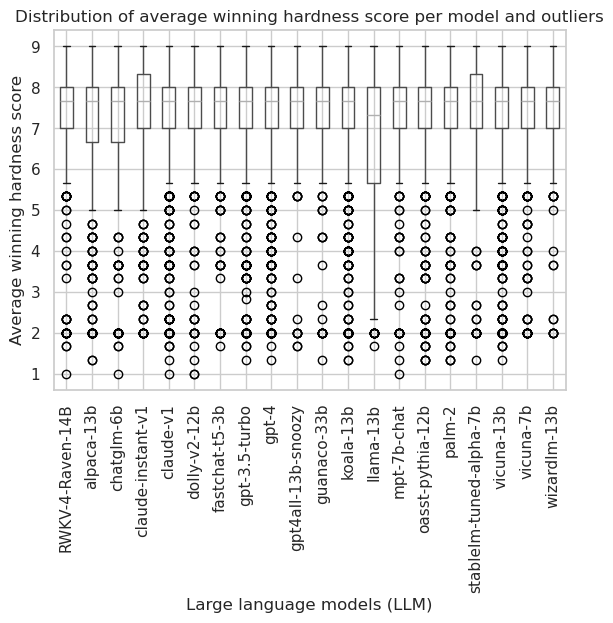

In [ ]:
# boxplot of the average hardness score per model

df_combined.boxplot(column='row_average', by='model', grid=True)
plt.title('Distribution of average winning hardness score per model and outliers')
plt.suptitle('')  
plt.xlabel('Large language models (LLM)')
plt.ylabel('Average winning hardness score')
plt.xticks(rotation=90) 
# plt.# savefig("figures/average_hardness_score_per_model.png", dpi=300, bbox_inches='tight')
plt.show()

In [226]:
df_counts = df_combined["model"].value_counts()

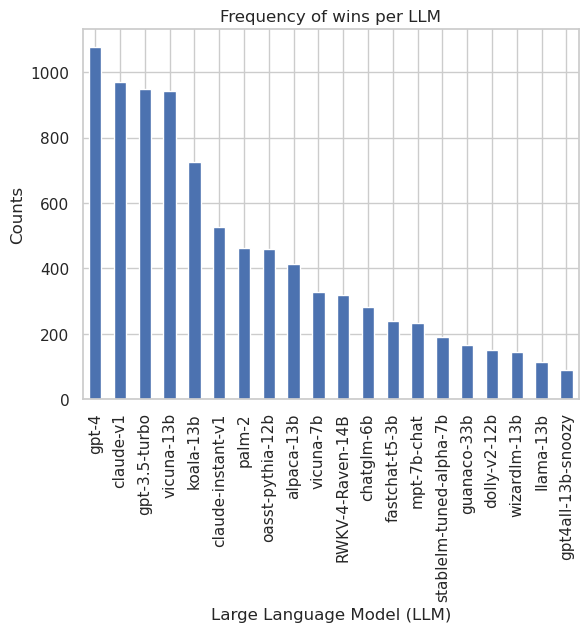

In [ ]:
# Number of times chatbot won in the chatbox arena. 
df_counts.plot(kind='bar', x='model')
plt.ylabel('Counts')
plt.xlabel('Large Language Model (LLM)')
plt.title("Frequency of wins per LLM");

# plt.# savefig("figures/frequency_of_wins_per_model.png", dpi=300, bbox_inches='tight')

In [229]:
df_topic_and_hardness[["model_b"]].value_counts()
df_topic_and_hardness[["model_a"]].value_counts()

model_a                
vicuna-13b                 1118
koala-13b                  1079
oasst-pythia-12b            928
gpt-3.5-turbo               883
alpaca-13b                  820
claude-v1                   789
gpt-4                       784
chatglm-6b                  688
RWKV-4-Raven-14B            666
palm-2                      600
fastchat-t5-3b              573
mpt-7b-chat                 543
vicuna-7b                   541
stablelm-tuned-alpha-7b     532
claude-instant-v1           514
dolly-v2-12b                501
llama-13b                   357
wizardlm-13b                199
gpt4all-13b-snoozy          198
guanaco-33b                 183
Name: count, dtype: int64

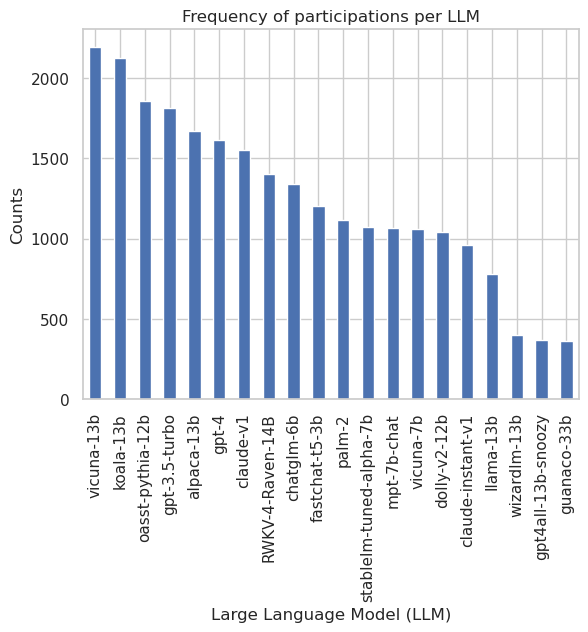

In [ ]:
model_b_counts = df_topic_and_hardness["model_b"].value_counts()
model_a_counts = df_topic_and_hardness["model_a"].value_counts()

model_a_counts.name = 'new_name'

combined_counts = model_b_counts.add(model_a_counts, fill_value=0)

combined_counts = combined_counts.sort_values(ascending = False)
combined_counts.plot(kind='bar', x='model')
plt.ylabel('Counts')
plt.xlabel('Large Language Model (LLM)')
plt.title("Frequency of participations per LLM");

# plt.# savefig("figures/frequency_of_participations_per_model.png", dpi=300, bbox_inches='tight')

In [231]:
combined_counts = model_b_counts.add(model_a_counts, fill_value=0)

In [232]:
combined_counts = model_b_counts + model_a_counts

In [233]:
ratio = pd.concat([df_counts,combined_counts], axis=1)

In [235]:
ratio["ratio_value"] = ratio.iloc[:,0] / ratio.iloc[:,1]

In [236]:
ratio = ratio.sort_values("ratio_value", ascending = False)

gpt-4                      0.666460
claude-v1                  0.626452
claude-instant-v1          0.547817
gpt-3.5-turbo              0.523416
guanaco-33b                0.457064
vicuna-13b                 0.429353
palm-2                     0.414722
wizardlm-13b               0.362500
koala-13b                  0.341027
vicuna-7b                  0.307838
oasst-pythia-12b           0.247312
alpaca-13b                 0.246264
gpt4all-13b-snoozy         0.241096
RWKV-4-Raven-14B           0.227208
mpt-7b-chat                0.218250
chatglm-6b                 0.210015
fastchat-t5-3b             0.199167
stablelm-tuned-alpha-7b    0.176909
llama-13b                  0.145431
dolly-v2-12b               0.143678
Name: ratio_value, dtype: float64

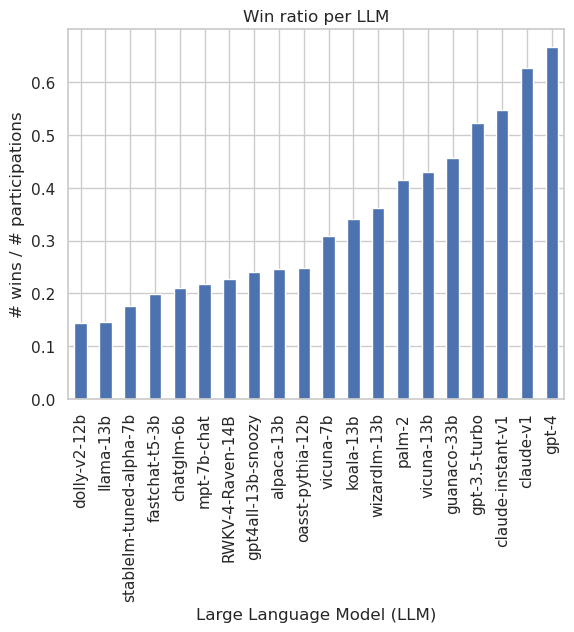

In [ ]:
ratio = ratio.sort_values("ratio_value") # number of wins / number of participations
ratio["ratio_value"].plot(kind='bar')
plt.ylabel('# wins / # participations')
plt.xlabel('Large Language Model (LLM)')
plt.title("Win ratio per LLM");
# plt.# savefig("figures/win_ratio_per_model.png", dpi=300, bbox_inches='tight')

In [239]:
ratio = ratio.rename(columns= {"count": "Winning counts", 0:"Total competitions", "ratio_value": "Win ratio"})

In [ ]:
winning_model_score = df_topic_and_hardness[['row_average', 'winning model']] # Updated to include relevant columns

row_average            winning model
0         5.333333  stablelm-tuned-alpha-7b
1         7.000000                claude-v1
2         8.666667                    gpt-4
3         9.000000                   palm-2
4         8.666667                    gpt-4
...            ...                      ...
12491     9.000000                claude-v1
12492     3.666667               vicuna-13b
12493     8.000000         RWKV-4-Raven-14B
12494     7.000000            gpt-3.5-turbo
12495     7.000000  stablelm-tuned-alpha-7b

[12496 rows x 2 columns]

In [ ]:
winning_model_score = winning_model_score[~(winning_model_score['winning model'] == 'tie')] # Updated to remove ties

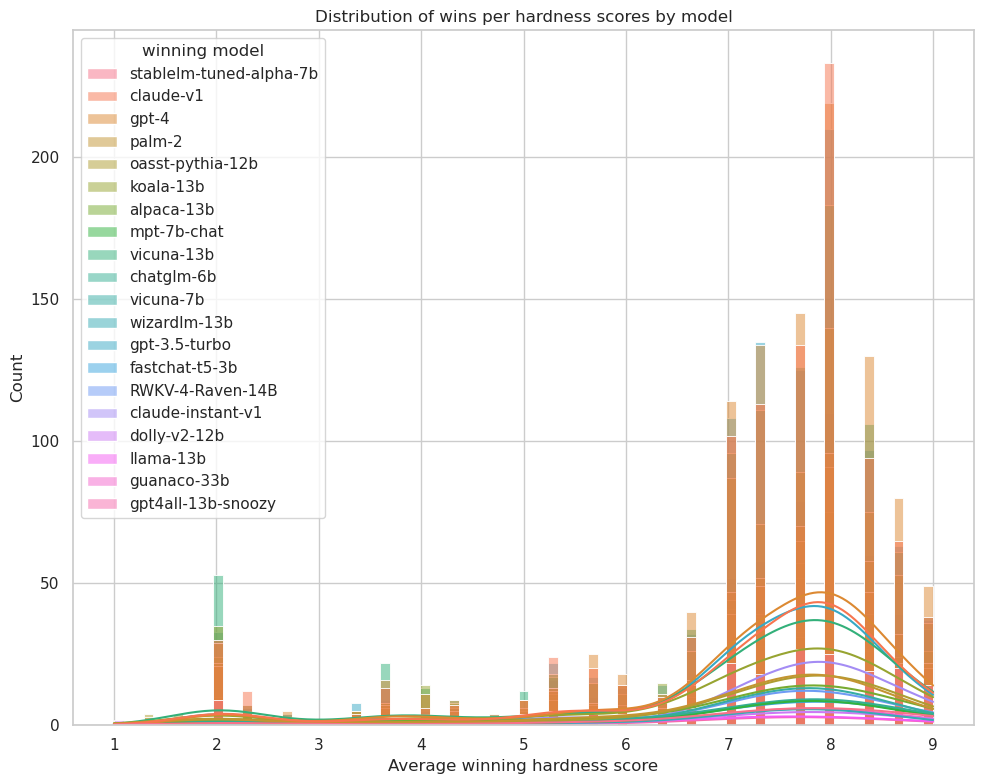

In [ ]:
# Task1 - Histograms - Distribution of score values per model (combined histograms per model) 
plt.figure(figsize=(10, 8))
ax = sns.histplot(data = winning_model_score, x='row_average', hue = 'winning model', kde = True) #multiple = "stack")
plt.xlabel('Average winning hardness score')
plt.title('Distribution of wins per hardness scores by model') 
plt.tight_layout()
# plt.# savefig("figures/distribution_of_wins_per_hardness_scores_by_model.png", dpi=300, bbox_inches='tight')

In [246]:
my_models = winning_model_score["winning model"].unique()

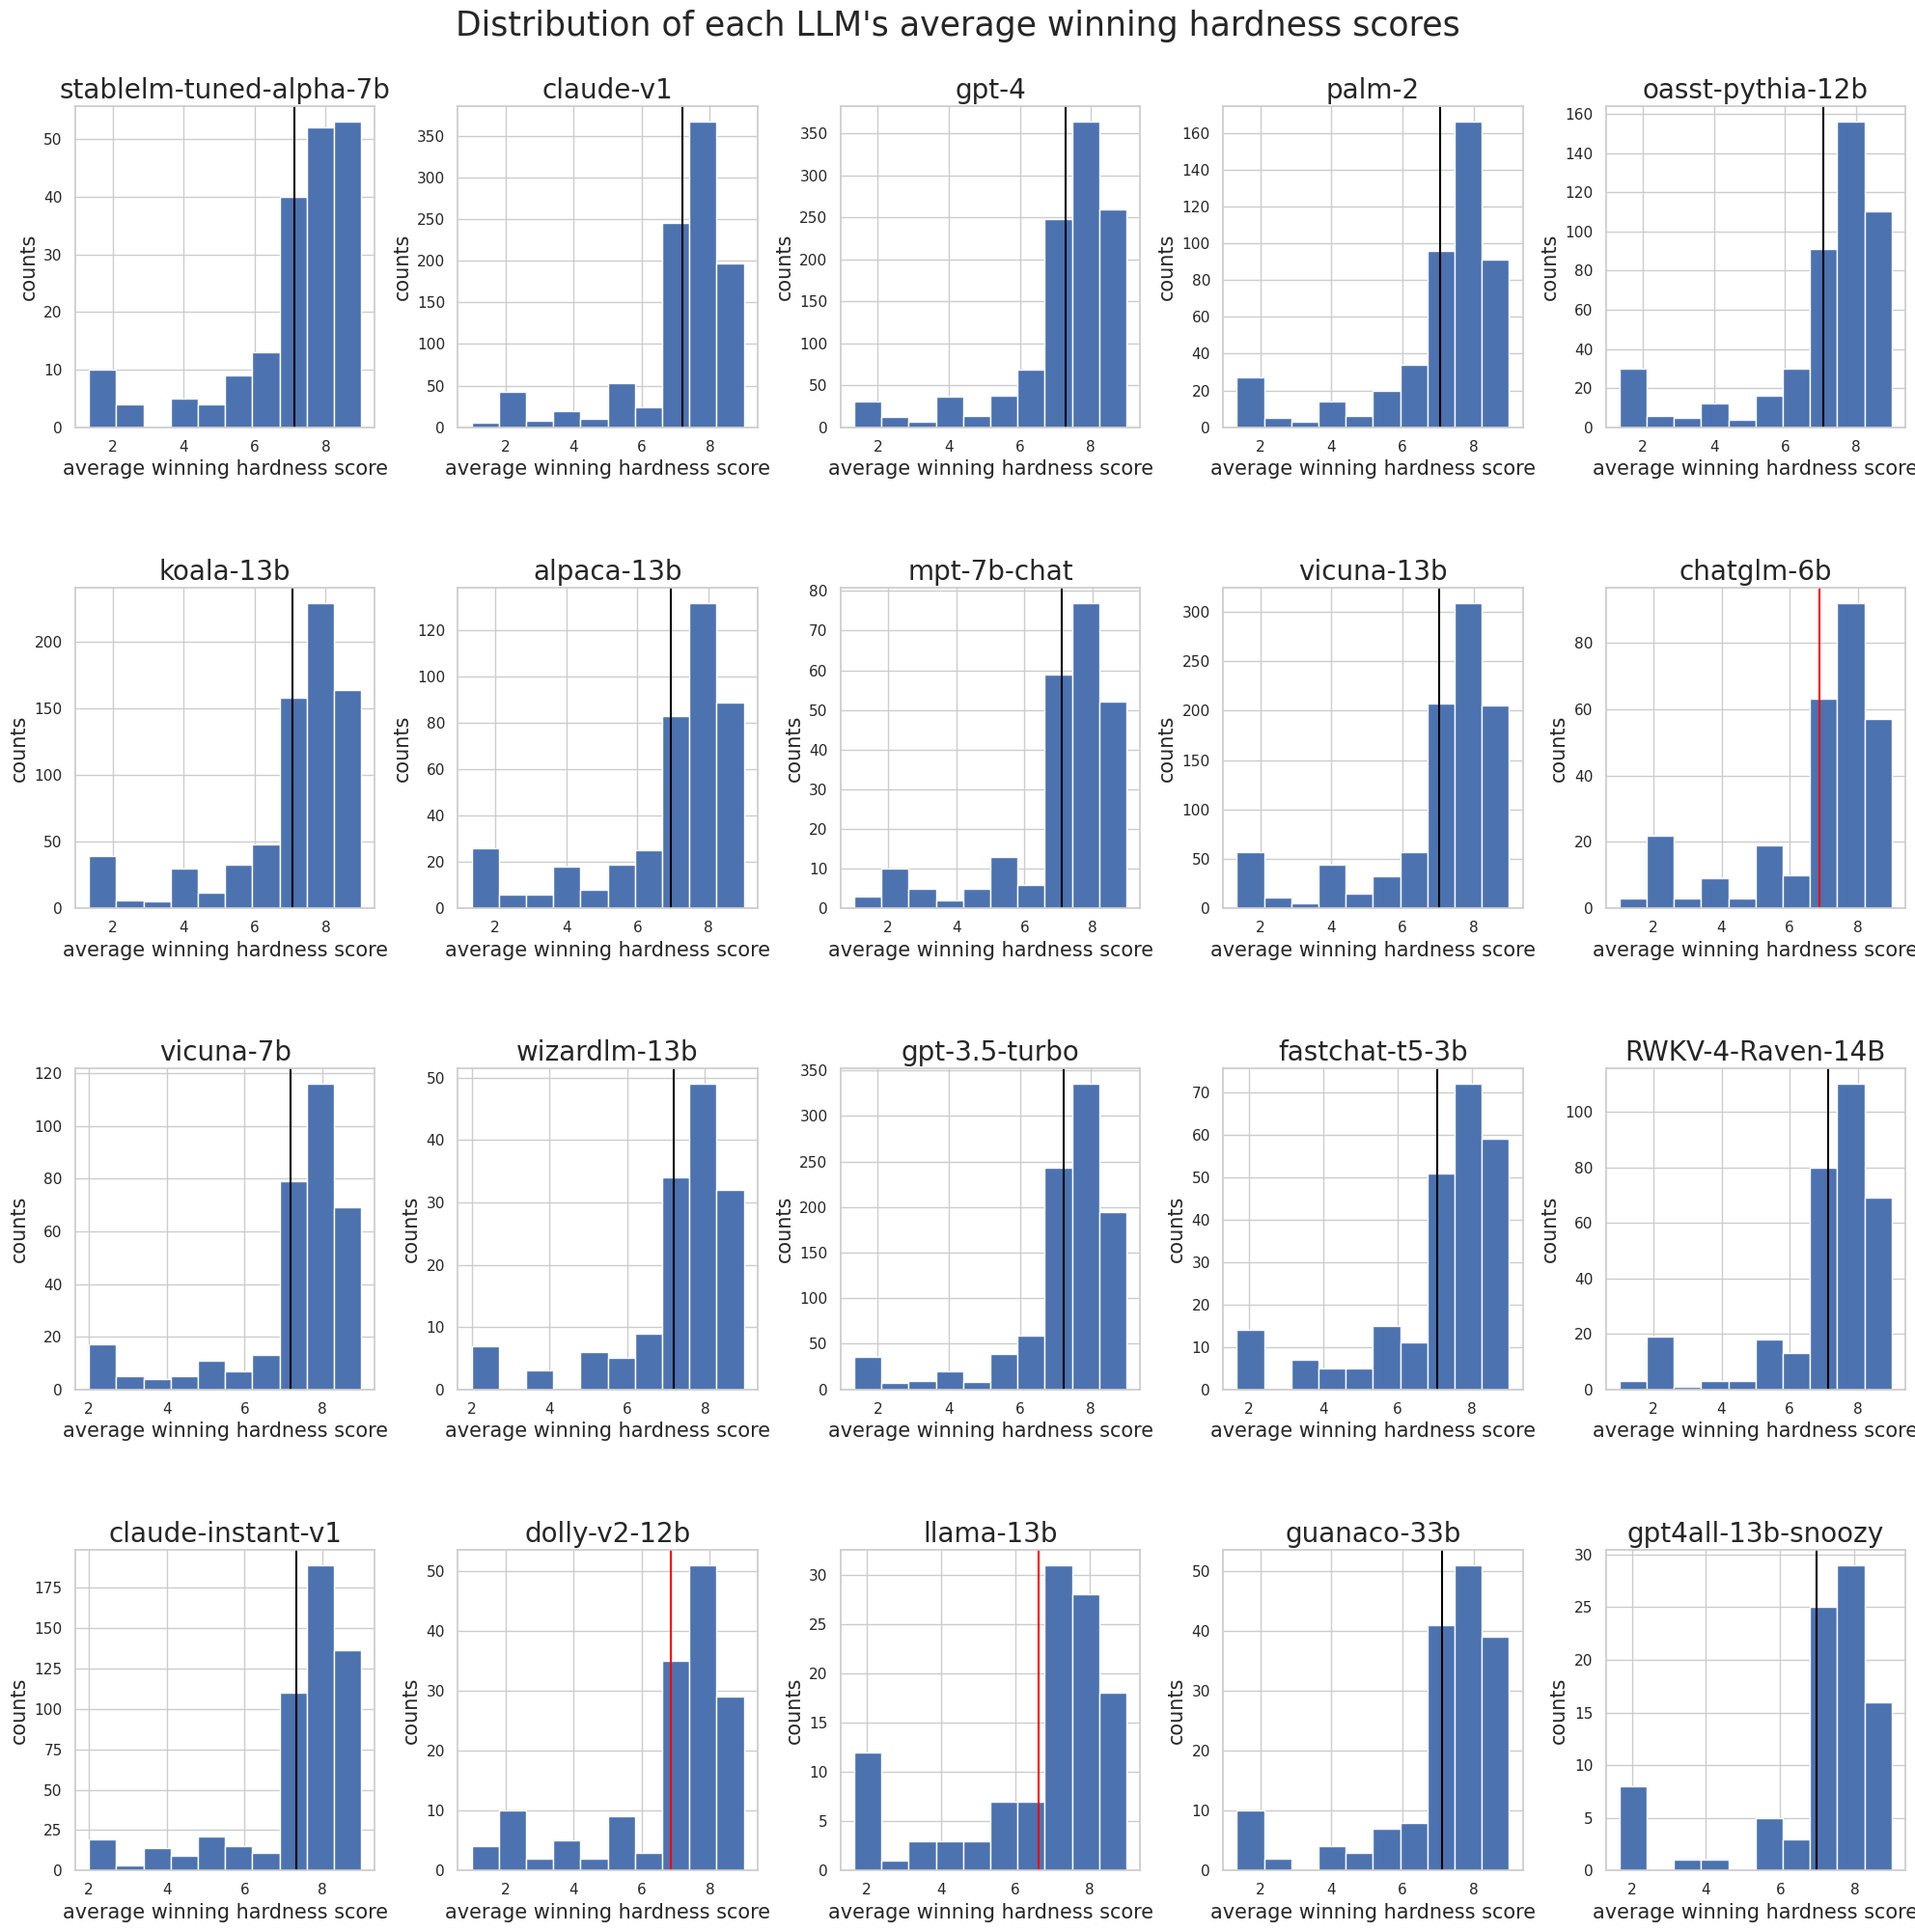

In [ ]:
fig, ax = plt.subplots (4, 5, figsize = (20,20)) # 20 subplots
for i in range(len(my_models)):
    row = i//5
    column = i%5
    condition = winning_model_score["winning model"] == my_models[i]
    ax[row, column].hist(data = winning_model_score[condition], x = "row_average")
    ax[row, column].set_xlabel("average winning hardness score", fontsize = 15)
    ax[row, column].set_ylabel("counts", fontsize = 15)
    ax[row, column].set_title(my_models[i], fontsize = 20)
    
    avg_value = winning_model_score[condition]["row_average"].mean()
    if avg_value > 6.9:
        ax[row, column].axvline(avg_value, color='black')
    else:
        ax[row, column].axvline(avg_value, color='red')

plt.suptitle("Distribution of each LLM's average winning hardness scores", fontsize = 25, y = 1)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
# fig.# savefig("figures/distribution_of_each_LLM_average_winning_hardness_scores.png", dpi=300, bbox_inches='tight')

In [249]:
# Answering question: What are the most common topics in the dataset?
# Answer: Creative Writing; Factual Accuracy; and Problem-selving, Creativity 

topic_modeling_1
Creative Writing               565
Factual Accuracy               510
Problem-solving, Creativity    398
Name: count, dtype: int64

topic_modeling_2
Creative Writing               586
Factual Accuracy               519
Problem-solving, Creativity    362
Name: count, dtype: int64

topic_modeling_3
Creative Writing               596
Factual Accuracy               487
Problem-solving, Creativity    407
Name: count, dtype: int64

In [250]:
# Answering question: What are the most common topics in the dataset?
topic_model_1 = topic_and_hardness[["topic_modeling_1", "score_value_1"]]
topic_model_2 = topic_and_hardness[["topic_modeling_2", "score_value_2"]]
topic_model_3 = topic_and_hardness[["topic_modeling_3", "score_value_3"]]

#topic_model_1.groupby("topic_modeling_1")['score_value_1'].agg("mean")
list_items = topic_model_1[topic_model_1['topic_modeling_1'].apply(lambda x: isinstance(x, list))]

                   topic_modeling_1  score_value_1
8632           [astronomy, planets]            2.0
16412            [Combat, Conflict]            6.0
22905  [videogames, recommendation]            7.0


In [251]:
def take_out_list(one_series_element):
    if isinstance(one_series_element, list):
        return one_series_element[0][0]
    else:
        return one_series_element

In [252]:
# If item in topic_modeling_1 is a list, take out first item in the list to be the topic model. 
score_value_1_cleaned = topic_and_hardness["topic_modeling_1"].apply(take_out_list)
score_value_1_cleaned

topic_and_hardness["topic_modeling_1"] = score_value_1_cleaned

In [253]:
# Answering question: Which topics tend to have higher hardness scores?
topics_hardness_nine = topic_and_hardness[["topic_modeling_1", "score_value_1"]].sort_values(by="score_value_1", ascending = False).groupby("topic_modeling_1").agg("first").sort_values(by="score_value_1", ascending = False)
condition = topics_hardness_nine["score_value_1"] == 9.0

score_value_1
topic_modeling_1                           
3D Modeling                             9.0
Interoperability, Healthcare            9.0
Installation, Hackintosh                9.0
Instruction Parsing                     9.0
Instruction, Compliance                 9.0
...                                     ...
Analysis, Summarization                 9.0
Argumentative Writing                   9.0
Cloud Adoption                          9.0
Algebra, Proof                          9.0
Business Idea                           9.0

[1913 rows x 1 columns]

Once you clean the dataset, you can start your analysis by think about the following questions:
- Do models perform differently based on hardness scores? <mark> No. Distribution of "winner" model vs. hardness of question is similar between model_a and model_b </mark>
- What are the most common topics in the dataset? <mark> Creative Writing; Factual Accuracy; and Problem-selving, Creativity </mark>
- Which topics tend to have higher hardness scores? <mark> There are 1913 topics that have a harness score of 9. </mark>